# Approach 2

Getting back into it after some time with a new approach for finding patterns. Initial exploration and analysis.

### Init

In [473]:
import polars as pl
from polars import selectors as cs
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm
import numpy as np
import scipy as sp
import seaborn as sns
from datetime import datetime


In [474]:
DEBUG = False
WINDOW_SIZE = 10


### Load and add dummy tickers

In [475]:
path = os.path.join('data', 'silver', 'prices_with_nrdy')

df = pl.read_parquet(path)

# dummy 1
dummy_dfs = []
k = np.log(1.1) / 260
dummy_1_f = lambda x: (100 * np.e ** (k * x) - 10 * (x // 50) + 10 / 50 * x)

dummy_dfs.append(df
    .filter(pl.col('ticker') == pl.lit('NRDY'))
    .with_columns(
        pl.lit('DUMMY1').alias('ticker'),
        dummy_1_f(pl.col('date').rank() - 1).alias('price')
    )
)

# dummy 2
size = dummy_dfs[0].shape[0]

np.random.seed(int(datetime.now().timestamp()))
noise = (np.random.random(size) -.5) * 20

dummy_dfs.append(dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY2').alias('ticker'),
       (pl.col('price') - pl.lit(noise)).alias('price') 
    )
)

# dummy 3 (more variance)

noise_2 = (np.random.random(size) -.5) * 100

dummy_dfs.append(dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY3').alias('ticker'),
       (pl.col('price') - pl.lit(noise_2)).alias('price') 
    )
)

# dummy 4 (spikes are uneven)
dummy_4_f = lambda x: 100 * np.e ** (k * x)
dummy_4_prices = [dummy_4_f(x) for x in range(size)]
i = 0
while i < size:
    i += 50 + np.random.randint(-10, 10)
    if i < size:
        dummy_4_prices[i] -= 10

print([print(x) for x in dummy_4_prices])

dummy_dfs.append(
    dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY4').alias('ticker'),
        pl.Series(dummy_4_prices).alias('price')
    )
)


df = pl.concat([df, *dummy_dfs])

display(df)

100.0
100.03666448124167
100.07334240532518
100.11003377717927
100.14673860173453
100.1834568839233
100.22018862867974
100.25693384093988
100.29369252564145
100.33046468772409
100.36725033212919
100.40404946379996
100.44086208768151
100.47768820872061
100.51452783186593
100.551380962068
100.58824760427908
100.62512776345325
100.66202144454648
100.69892865251649
100.73584939232285
100.77278366892692
100.80973148729191
100.84669285238283
100.88366776916655
100.92065624261166
100.9576582776887
100.99467387936996
101.03170305262952
101.06874580244339
101.1058021337893
101.14287205164688
101.17995556099753
101.21705266682453
101.2541633741129
101.2912876878496
101.32842561302336
101.3655771546247
101.40274231764607
101.43992110708166
101.47711352792751
101.51431958518154
101.55153928384347
101.5887726289148
101.62601962539897
101.66328027830116
101.70055459262845
101.73784257338974
101.77514422559572
101.812459554259
101.84978856439393
101.8871312610168
101.92448764914566
101.96185773380044

date,ticker,price
date,str,f64
1994-03-18,"""SCSC""",1.71875
1994-03-21,"""SCSC""",1.90625
1994-03-22,"""SCSC""",1.9375
1994-03-23,"""SCSC""",2.09375
1994-03-24,"""SCSC""",2.09375
…,…,…
2024-04-26,"""DUMMY4""",136.910469
2024-04-29,"""DUMMY4""",136.960667
2024-04-30,"""DUMMY4""",137.010882


### Plot price over time

In [476]:
def plot_price(df, ticker=None, x='date', y='price'):
    if not ticker:
        ticker = ''

    dates = df[x]
    prices = df[y]

    fig, ax = plt.subplots()
    ax.plot(dates, prices)
    # ax.scatter(dates, prices, s=5)
    plt.title(ticker)
    plt.show()
    

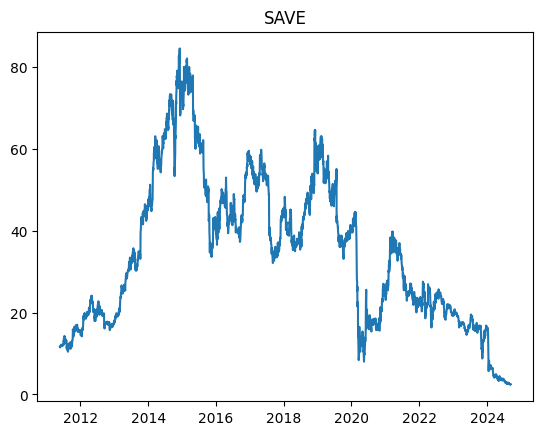

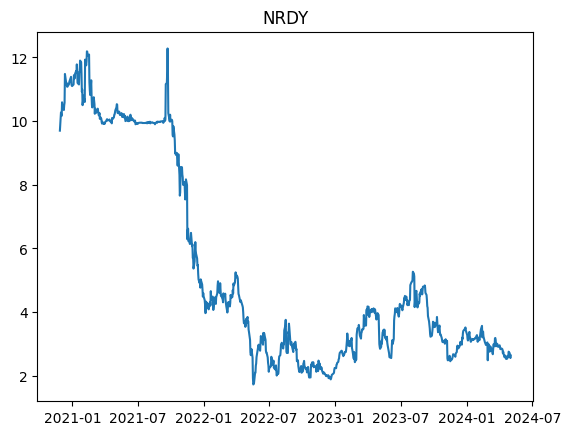

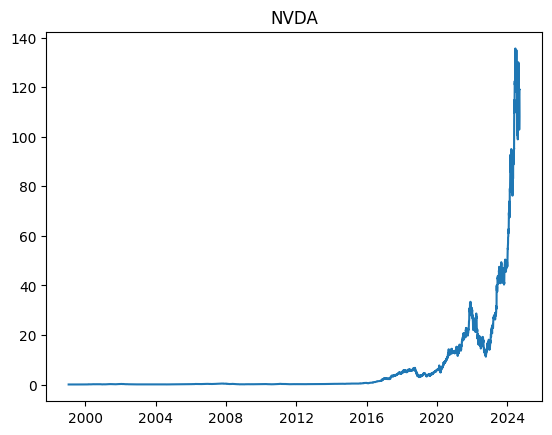

In [477]:
test_tickers = ['NRDY', 'NVDA', 'SAVE']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

for ticker, group_df in filtered_df.group_by('ticker'):
    plot_price(group_df, ticker[0])



### Detrending

In [478]:
def plot_detrended(ticker, actuals, predictions, adjusted):
    x = list(range(0, len(actuals)))

    fig, ax = plt.subplots()
    ax.scatter(x, actuals, s=5)
    ax.plot(x, predictions)
    ax.plot(x, adjusted)
    ax.set_title(ticker)
    plt.xticks(rotation=45)
    plt.show()

In [479]:
def detrend_lin_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    ticker = df['ticker'][0]

    df = df.sort(pl.col('date'))

    rows, cols = df.shape

    # create X and y
    X = list(range(0, rows))
    X = sm.add_constant(X)
    y = df['price'].to_numpy()

    # fit model
    model = sm.OLS(y, X)
    results = model.fit()

    # make predictions
    predictions = results.predict()

    # detrend using model predictions
    df = df.with_columns(pl.col('price') - predictions)

    if DEBUG:
        print(results.summary())

        plot_detrended(ticker, y, predictions, df['price'])
    
    return df



In [480]:
def detrend_exp_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns

    df = df.with_columns(pl.col('price').log1p())

    df = detrend_lin_reg(df)

    return df



In [481]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_lin_reg)

In [482]:
DEBUG = False
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_exp_reg)

Regression detrending isn't working well on tickers that have two distinct trends. 

In [483]:
def detrend_moving_avg(df):
    # checks
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    # get ticker
    ticker = df['ticker'][0]

    # calculate rolling average
    df = df.sort(pl.col('date')) \
    .with_columns(pl.col('price').rolling_mean(WINDOW_SIZE).alias('rolling_avg')) \
    .with_columns(((pl.col('price') - pl.col('rolling_avg')) / pl.col('rolling_avg')).alias('adjusted'))

    if DEBUG:
        with pl.Config(tbl_rows=218):
            display(df)
            
        plot_detrended(ticker, df['price'], df['rolling_avg'], df['adjusted'])

    # remove and rename unneeded columns
    df = df.select(pl.col('date'), pl.col('ticker'), pl.col('adjusted').alias('price'))

    
    return df



##### Testing detrending

In [484]:
DEBUG = False
test_tickers = ['NRDY', 'NVDA', 'DUMMY1'] + df['ticker'].unique().to_list()[:5]
test_tickers = ['DUMMY1']

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_moving_avg)

Rolling average seems to be the best option.

In [485]:
def fft(df):
    y = df['price'].to_numpy()

    N = y.shape[-1]


    # a = sp.sin(list(range(0, a.shape[-1])))

    yf = sp.fft.fft(y)

    if DEBUG:
        xf = sp.fft.fftfreq(N)[:N//2]

        fig, ax = plt.subplots()
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

        plt.show()
        # display(xf)


    return df

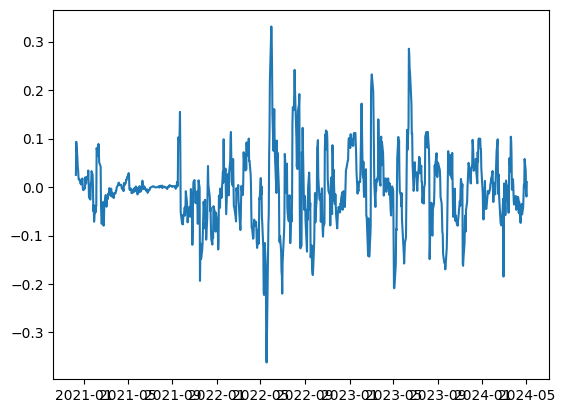

In [486]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:1]
test_tickers = test_tickers[:1]

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

DEBUG = False
detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    # .with_columns(pl.when(abs(pl.col('price')) > 1.1).then(pl.col('price')).otherwise(0).alias('price'))
)

plot_price(detrended_df)
DEBUG = False
fft_df = detrended_df.group_by('ticker').map_groups(fft)
# display(fft_df)

### Smoothing function

In [487]:
smoothing_distance = 10
sx_int = lambda x: -1 / 3 * x ** 3 + smoothing_distance ** 2 * x
A = sx_int(smoothing_distance) - sx_int(-smoothing_distance)

smoothing_function = lambda x: -1 / A * (x - smoothing_distance) * (x + smoothing_distance)

print(A)

1333.3333333333335


In [538]:
def plot_psd(xf, psd, min_wavelength=None, max_wavelength=None):
    if min_wavelength:
        xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
        xf = np.array(xf)
        psd = np.array(psd)

    if max_wavelength:
        xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))
        xf = np.array(xf)
        psd = np.array(psd)
        
    fig, ax = plt.subplots()
    sns.lineplot(x=xf, y=psd, errorbar=None)

    xtick_indices = [int(x) for x in np.linspace(1, len(xf)-1, 10)]
    xticks = xf[xtick_indices]
    xtick_labels = np.round(([*1/xf[xtick_indices]]), 1)
    plt.xticks(xticks, xtick_labels)

    max_points = sorted(zip(xf, psd), key=lambda x: x[1], reverse=True)
    for max_point in max_points[:3]:
        plt.text(max_point[0], max_point[1], np.round(1/max_point[0], 1))
    
    plt.title(ticker)
    plt.show()



### Testing FFT

['NRDY', 'DUMMY1', 'DUMMY3', 'DUMMY2', 'DUMMY4']


x_right,x,y
f64,f64,f64
850.997653,850.997653,-0.000126
34.039906,52.061033,-0.001847
170.199531,239.280516,-0.004388
742.870892,775.909624,-0.001005
469.550469,498.584507,-0.00215
…,…,…
147.172535,168.197183,-0.000009
815.956573,837.982394,-0.001927
784.920188,806.946009,-0.002372


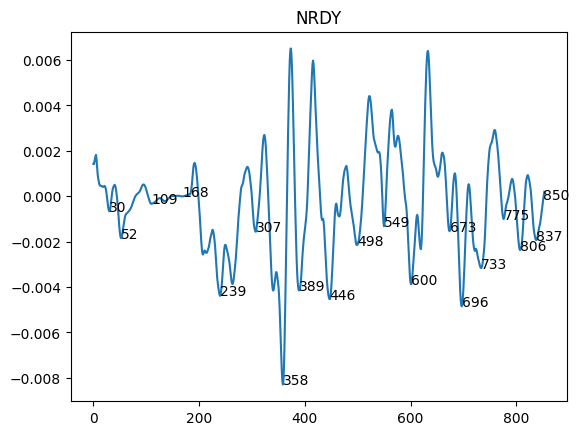

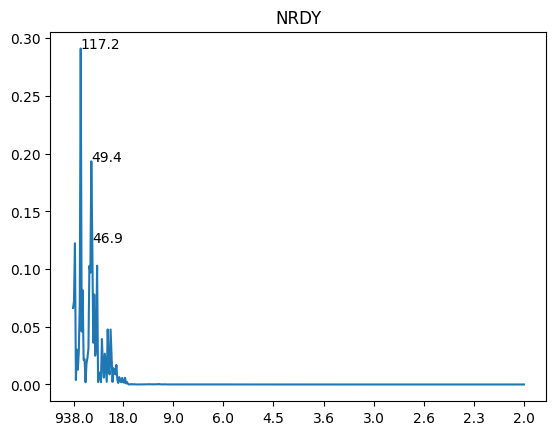

/tmp/ipykernel_2391/2923173563.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
/tmp/ipykernel_2391/2923173563.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))


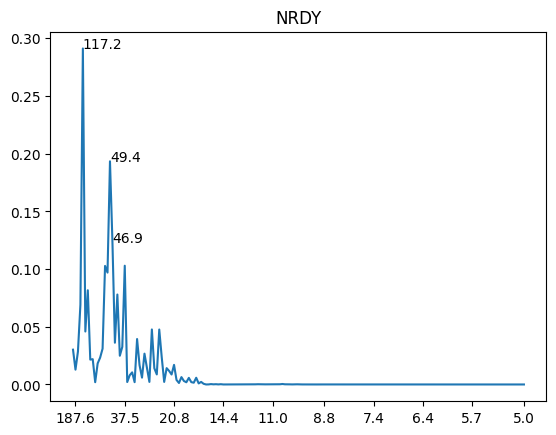

x_right,x,y
f64,f64,f64
101.118545,144.169014,-0.000954
801.940141,844.99061,-0.000734
451.529343,494.579812,-0.000835
51.059859,94.110329,-0.000972
401.470657,444.521127,-0.000852
…,…,…
251.294601,294.34507,-0.000902
651.764085,694.814554,-0.000774
301.353286,344.403756,-0.000885


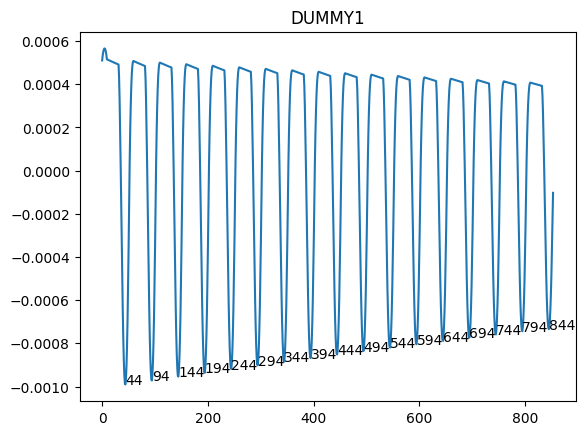

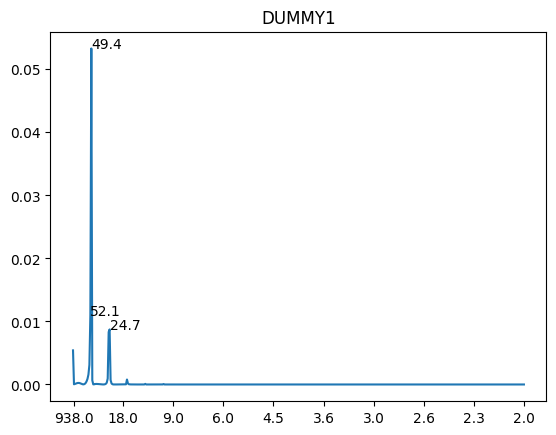

/tmp/ipykernel_2391/2923173563.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
/tmp/ipykernel_2391/2923173563.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))


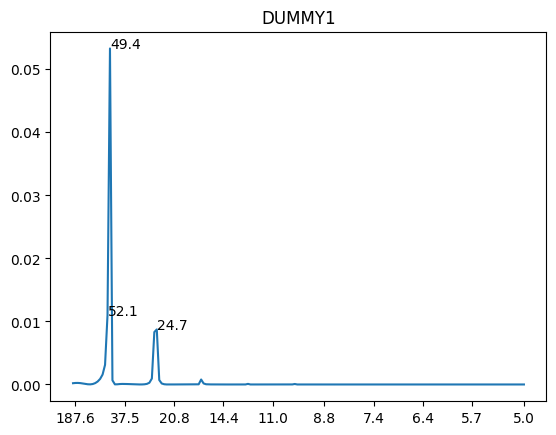

x_right,x,y
f64,f64,f64
824.967136,843.989437,-0.000629
545.639671,564.661972,-0.000876
408.478873,427.501174,-0.001077
846.992958,846.992958,-0.000022
482.565728,497.583333,-0.004583
…,…,…
651.764085,651.764085,-0.000042
575.674883,589.691315,-0.000944
19.0223,35.04108,-0.001291


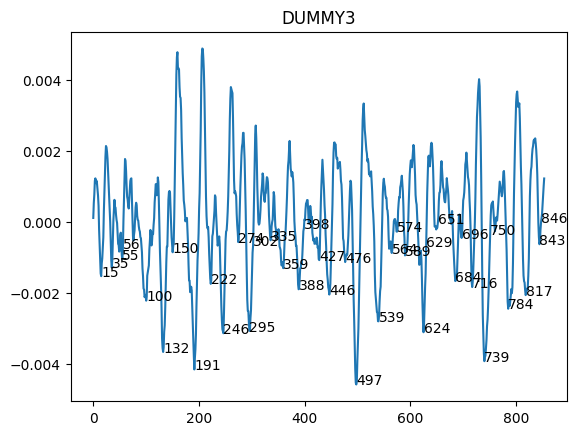

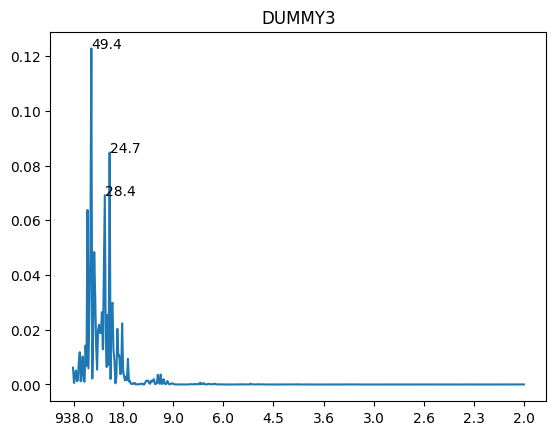

/tmp/ipykernel_2391/2923173563.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
/tmp/ipykernel_2391/2923173563.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))


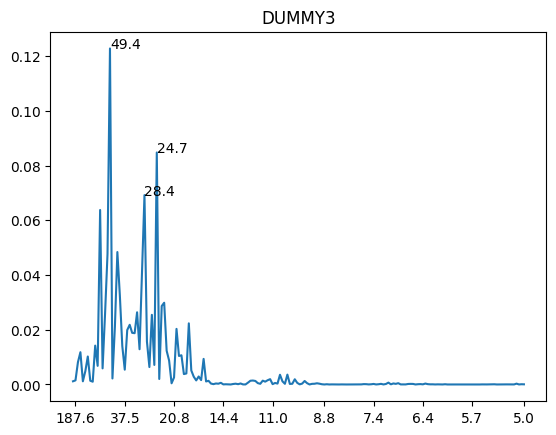

x_right,x,y
f64,f64,f64
622.730047,644.755869,-0.00136
114.133803,146.171362,-0.000654
504.591549,544.638498,-0.001332
550.64554,592.694836,-0.001375
803.942488,847.994131,-0.001316
…,…,…
200.234742,200.234742,-0.000192
454.532864,496.58216,-0.001454
60.070423,92.107981,-0.000961


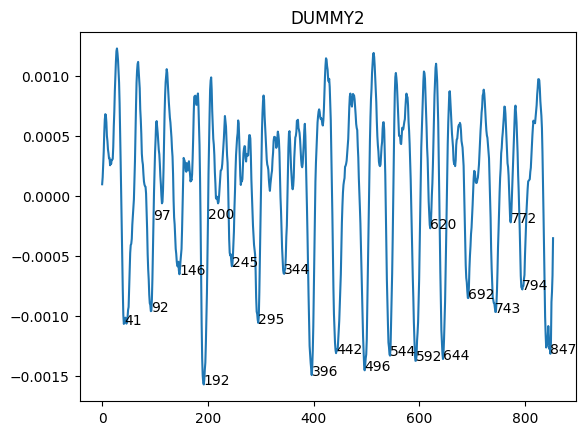

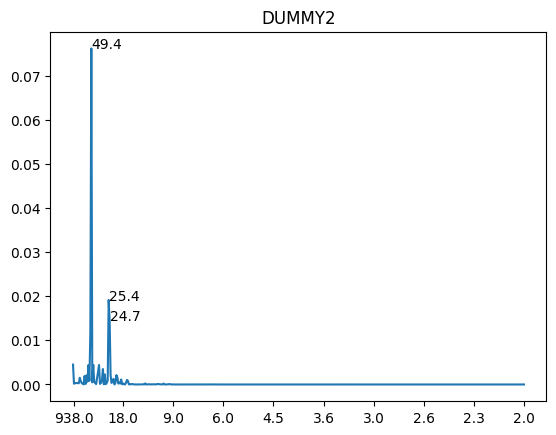

/tmp/ipykernel_2391/2923173563.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
/tmp/ipykernel_2391/2923173563.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))


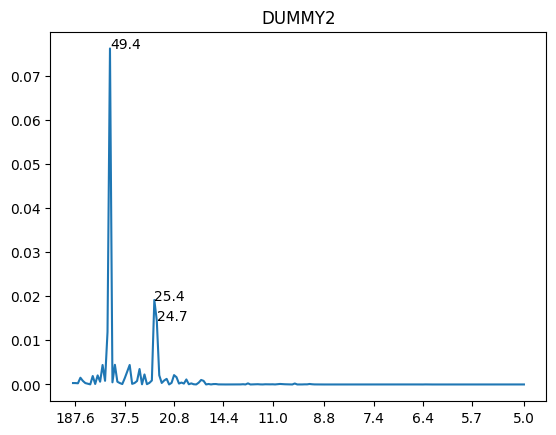

x_right,x,y
f64,f64,f64
338.396714,379.444836,-0.000085
728.85446,766.899061,-0.000063
46.053991,101.118545,-0.000103
485.569249,525.616197,-0.000076
204.239437,242.284038,-0.000094
…,…,…
639.75,681.799296,-0.000068
440.516432,481.564554,-0.000079
105.123239,155.181925,-0.0001


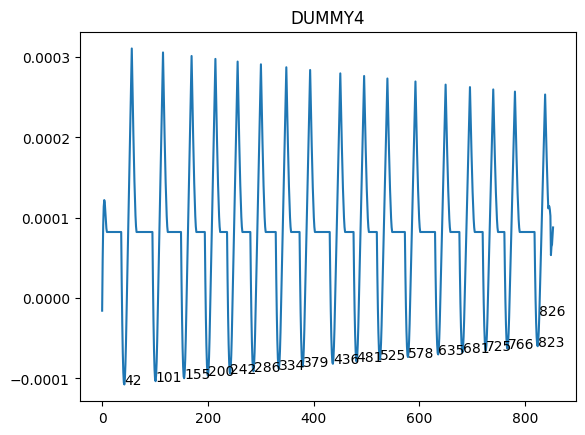

/tmp/ipykernel_2391/2923173563.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  plt.text(max_point[0], max_point[1], np.round(1/max_point[0], 1))


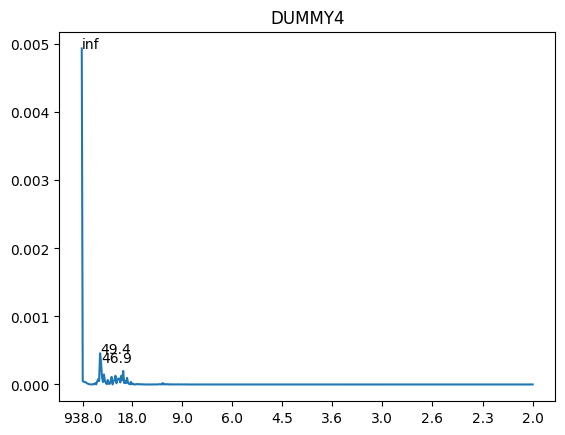

/tmp/ipykernel_2391/2923173563.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
/tmp/ipykernel_2391/2923173563.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))


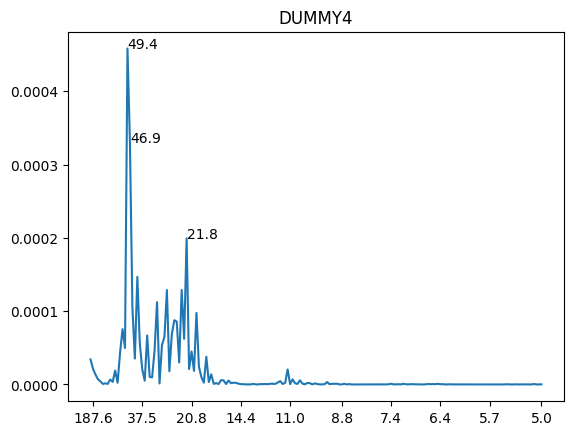

In [541]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]
# test_tickers = [test_tickers[5]]
# test_tickers = ['NRDY']
# dummy_tickers = df.filter(pl.col('ticker').str.head(5) == 'DUMMY')['ticker'].unique().to_list()
test_tickers = ['NRDY', *dummy_tickers]
# test_tickers = ['DUMMY4']

print(test_tickers)

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))
WINDOW_SIZE = 10
DEBUG = False

detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    # .with_columns(pl.when(abs(pl.col('price')) > .1).then(pl.col('price')).otherwise(0).alias('price'))
    .with_columns(pl.mean_horizontal(
        *[pl.col('price').shift(i) * smoothing_function(i) for i in range(-smoothing_distance, smoothing_distance)]
    ).alias('price'))
)

for ticker in test_tickers:
    ticker_df = detrended_df.filter(pl.col('ticker') == pl.lit(ticker))
    

    N = ticker_df.shape[0]
    x_all = np.linspace(0, N, N)
    y_all = ticker_df['price'].to_numpy()

    overlap = .1
    windows = 1
    L = y_all.shape[-1]
    W = L // windows
    N = int(W * (1 + overlap) // 1)

    # for padding in [0, 50, 100, 500, 1000, -1000]:
    for window in range(windows):
        start = int(window * W)
        end = int(min(start + N, L) // 1)

        x = x_all[start: end]
        y = y_all[start: end]

        yf = sp.fft.fft(y, n=N)[:N//2]

        xf = sp.fft.fftfreq(N)[:N//2]

        psd = np.abs(yf) ** 2

        # plotting local minimums
        fig, ax = plt.subplots()

        plt.plot(x, y)
        min_points_df = pl.DataFrame({'x': x, 'y': y})
        first_negatives_df = min_points_df.filter((pl.col('y') < 0, pl.col('y').shift(-1) >= 0)).with_columns(pl.col('x').alias('x_right'))
        
        min_points_df = (min_points_df
            .join_asof(first_negatives_df, on='x')
            .group_by(pl.col('x_right'))
            .agg(x=pl.col('x').get(pl.col('y').arg_min()), y=pl.col('y').min())              
        )

        display(min_points_df)
        for row in min_points_df.iter_rows():
            plt.text(row[1], row[2], int(row[1]))

        plt.title(ticker) 
        plt.show()

        plot_psd(xf, psd)
        plot_psd(xf, psd, 5, 300)